In [2]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import scipy.stats
import tqdm
import torch
from torch import tensor, Tensor
import transformers

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import mpl_toolkits.axes_grid1.inset_locator
import pandas as pd
import seaborn as sns

import block_formats.analysis as A
import block_formats.experiments as E
import block_formats.fit as F
import block_formats.quantisation as Q
import plot_utils

plot_utils.configure()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNDERLAY_ARGS = dict(zorder=0, ls=(0, (4, 1)), alpha=.5, lw=4, marker="x", ms=6)

def distribution_name(distribution: A.Distribution) -> str:
    if isinstance(distribution, A.StudentT):
        return f"t[$\\nu={distribution.df:.0f}$]"
    return type(distribution).__name__

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


## Optimal formats - examples

### `eg_normal_crd_4bit`

remote: Updating references: 100% (1/1)           


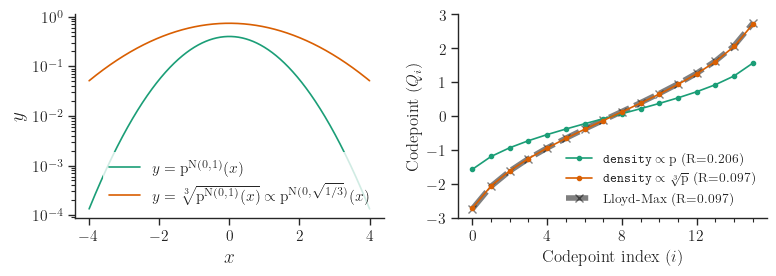

In [36]:
bits = 4
samples = 2**24

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

x = torch.linspace(-4, 4, 1001)
ax0.plot(x, scipy.stats.norm.pdf(x), label=r"$y = \mathrm{p}^{\mathrm{N}(0, 1)}(x)$")
ax0.plot(x, scipy.stats.norm.pdf(x)**(1/3), label=r"$y = \sqrt[3]{\mathrm{p}^{\mathrm{N}(0, 1)}(x)} \propto \mathrm{p}^{\mathrm{N}(0, \sqrt{1/3})}(x)$")
ax0.set_yscale("log")
ax0.set_xlabel("$x$")
ax0.set_ylabel(r"$y$")
ax0.legend(loc="lower right")

dist = A.Normal()
X = dist.sample(samples, seed=1, device=DEVICE)
for fmt in [
        Q.crd_normal(bits, power=1),
        Q.crd_normal(bits),
        Q.lut_lloyd_max(dist.sample(samples, seed=2, device=DEVICE), bits, 1e-4, init=("uniform_rms", 3)),
    ]:
    name = {
        "CRD{1}-N-RS": r"$\texttt{density} \propto \mathrm{p}$",
        "CRD-N-RS": r"$\texttt{density} \propto \sqrt[3]{\mathrm{p}}$",
        "LM": r"Lloyd-Max",
    }[fmt.name]
    rmse = Q.qrmse_norm(fmt, X).item()
    ax1.plot(fmt.values, label=f"{name} (R={rmse:.3f})",
             **(dict(UNDERLAY_ARGS, c="k") if fmt.name == "LM" else dict(marker="o")))
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(4))
ax1.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax1.set_xlabel("Codepoint index ($i$)", fontsize=12)
ax1.set_ylabel("Codepoint $(Q_i)$", fontsize=12)
ax1.legend(loc="lower right", fontsize=9.5)
ax1.set_xticks(list(range(2**bits)), minor=True)

plot_utils.tidy(fig)
plot_utils.save("eg_normal_crd_4bit")

### `eg_crd_curves_4bit`

remote: Updating references: 100% (1/1)           


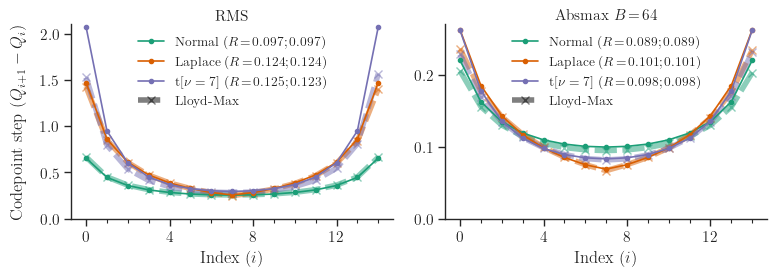

In [34]:
bits = 4
samples = 2**22
t_df = 7
block_size = 64

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

def lut_diff(fmt: Q.LUTFormat) -> Tensor:
    return tensor(fmt.values[1:]) - tensor(fmt.values[:-1])

dists = [
    A.Normal(scale=1),
    A.Laplace(scale=2**-0.5),
    A.StudentT(df=t_df, scale=((t_df - 2) / t_df) ** .5),
]
for dist, color in zip(dists, plot_utils.PALETTE):
    torch.manual_seed(1)
    X = dist.sample(samples, seed=1, device=DEVICE)
    X_LM = dist.sample(samples, seed=2, device=DEVICE)
    assert 0.95 <= A.rms(X).item() <= 1.05

    crd_fmt = dist.quantiser(bits)
    rmse = Q.qrmse_norm(crd_fmt, X).item()
    lm_fmt = Q.lut_lloyd_max(X_LM, bits, 1e-4, init=("uniform_rms", 3))
    lm_rmse = Q.qrmse_norm(lm_fmt, X).item()

    ax0.plot(lut_diff(crd_fmt), label=f"{distribution_name(dist)} ($R\\!=\\!{rmse:.3f} ; {lm_rmse:.3f}$)", c=color, marker="o")
    ax0.plot(lut_diff(lm_fmt), c=color, **UNDERLAY_ARGS)

    block_crd_fmt = dist.quantiser(bits, "absmax", block_size)
    block_rmse = Q.qrmse_norm(Q.LinearScalingFormat(block_crd_fmt, Q.BFLOAT16, (block_size,), scaling="absmax"), X).item()
    block_lm_fmt = Q.lut_lloyd_max(Q.block_normalise(X_LM, (block_size,), "absmax", (-1, 1), Q.FP32)[0], bits, 1e-4, init="uniform_minmax")
    block_lm_rmse = Q.qrmse_norm(Q.LinearScalingFormat(block_lm_fmt, Q.BFLOAT16, (block_size,), scaling="absmax"), X).item()

    ax1.plot(lut_diff(block_crd_fmt), label=f"{distribution_name(dist)} ($R\\!=\\!{block_rmse:.3f} ; {block_lm_rmse:.3f}$)", c=color, marker="o")
    ax1.plot(lut_diff(block_lm_fmt), c=color, **UNDERLAY_ARGS)

for ax in [ax0, ax1]:
    ax.set_xlabel("Index ($i$)", fontsize=12)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(4))
    ax.xaxis.set_ticks(list(range(2**bits - 1)), minor=True)
    h, _ = ax.get_legend_handles_labels()
    h.append(matplotlib.lines.Line2D([], [], color="k", **UNDERLAY_ARGS, label="Lloyd-Max"))
    ax.legend(handles=h, loc="upper center", fontsize=9.5)

ax0.set_ylim((0, 2.1))
ax1.set_ylim((0, 0.27))
ax1.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))

ax0.set_ylabel("Codepoint step $\\left(Q_{i+1} - Q_i\\right)$", fontsize=12, labelpad=10)
ax0.set_title("RMS", y=1, va="center")
ax1.set_title(f"Absmax $B\\!=\\!{block_size}$", y=1, va="center")

plot_utils.tidy(fig)
plot_utils.save("eg_crd_curves_4bit")

### `eg_dist_absmax`

remote: Updating references: 100% (1/1)           


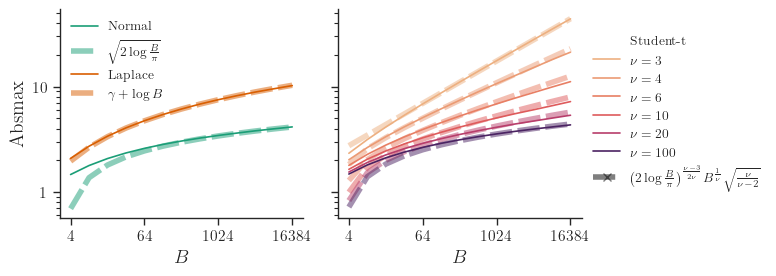

In [8]:
samples = 2**22
B = tensor([2**n for n in range(2, 14+1)])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3), sharey=True)

for color, dist in zip(plot_utils.PALETTE, [A.Normal(), A.Laplace()]):
    X = dist.sample(samples, seed=1, device=DEVICE)
    ax0.plot(B, [X.view(-1, Bi).abs().amax(-1).mean().item() for Bi in B], c=color, label=distribution_name(dist))
    if isinstance(dist, A.Normal):
        model = B.div(torch.pi).log().mul(2).sqrt()
        model_label = r"$\sqrt{2 \log \frac{B}{\pi}}$"
    if isinstance(dist, A.Laplace):
        model = B.log().add(0.57721566)
        model_label = r"$\gamma + \log B$"
    ax0.plot(B, model, **{**UNDERLAY_ARGS, "marker": None}, c=color, label=model_label)
ax0.legend(loc="upper left", fontsize=9.5)

t_dfs = tensor([3, 4, 6, 10, 20, 100])
for df, color in zip(t_dfs, plot_utils.SEQ_PALETTE(matplotlib.colors.LogNorm()(t_dfs))):
    X = A.StudentT(df.item()).sample(samples, seed=1, device=DEVICE)
    ax1.plot(B, [X.view(-1, Bi).abs().amax(-1).mean().item() for Bi in B], c=color, label=f"$\\nu={df:.0f}$")
    model = B.double().div(torch.pi).log().mul(2).pow((df-3)/2).mul(B).pow(1/df).mul((df/(df-2)).sqrt())
    ax1.plot(B, model, **{**UNDERLAY_ARGS, "marker": None}, c=color)
model_label = r"$\left(2 \log \frac{B}{\pi}\right)^{\frac{\nu-3}{2 \nu}}\! B^{\frac{1}{\nu}} \sqrt{\frac{\nu}{\nu - 2}}$"
h, _ = ax1.get_legend_handles_labels()
h.insert(0, matplotlib.lines.Line2D([], [], alpha=0, label="Student-t"))
h.append(matplotlib.lines.Line2D([], [], color="k", **UNDERLAY_ARGS, label=model_label))
ax1.legend(handles=h, bbox_to_anchor=(1, 0.5), loc="center left", fontsize=9.5)

for ax in [ax0, ax1]:
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.set_xticks([4, 64, 1024, 16384])
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.set_xlabel("$B$")
ax0.set_ylabel("Absmax")

plot_utils.tidy(fig)
plot_utils.save("eg_dist_absmax")

### `eg_scaling_mode_3bit_normal`

remote: Updating references: 100% (1/1)           


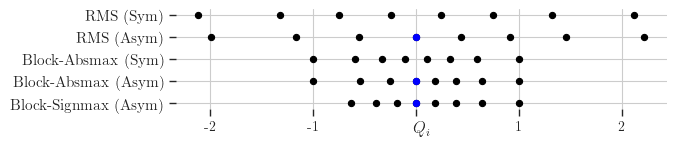

In [19]:
bits = 3
block_size = 64
dist = A.Normal()

_, ax = plt.subplots(figsize=(7, 1.7))

quantisers = [
    (dict(mode="symmetric"), dict(label="RMS (Sym)")),
    (dict(mode="asymmetric"), dict(label="RMS (Asym)")),
    (dict(scaling="absmax", block_size=block_size, mode="symmetric"), dict(label="Block-Absmax (Sym)")),
    (dict(scaling="absmax", block_size=block_size, mode="asymmetric"), dict(label="Block-Absmax (Asym)")),
    (dict(scaling="signmax", block_size=block_size, mode="asymmetric"), dict(label="Block-Signmax (Asym)")),
]
for y, (q, args) in enumerate(quantisers):
    ys = torch.full((2**bits,), -y)
    values = tensor(dist.quantiser(bits, **q).values)
    ax.scatter(values, ys, **args, color="k", s=20)
    zero = values.abs() < 1e-8
    ax.scatter(values[zero], ys[zero], color="b", s=20)


ax.grid(True)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
labels = ax.get_legend_handles_labels()[1]
ax.set_yticks(-torch.arange(len(labels)), labels, fontsize=11)
ax.set_ylim((-len(labels) + 1 - 0.25, 0.25))
ax.set_xlabel("$Q_i$", labelpad=-8, fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2], [-2, -1, "", 1, 2], fontsize=10)

plot_utils.tidy(ax.figure)
plot_utils.save("eg_scaling_mode_3bit_normal")

### `eg_block_scaled_distribution`

remote: Updating references: 100% (1/1)           


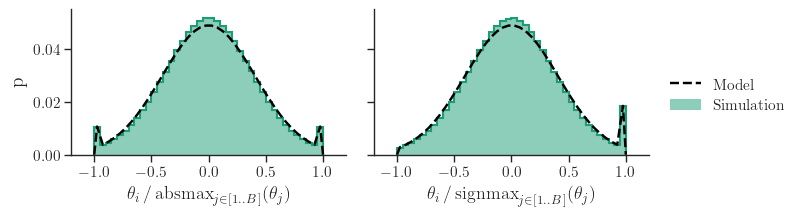

In [20]:
block_size = 64
X = A.Normal().sample(2**24, seed=1, device=DEVICE)
bins = torch.linspace(-1, 1, 41)

figw, figh = matplotlib.rcParams["figure.figsize"]
grid = plot_utils.grid(cols=["absmax", "signmax"], sharey=True, height=0.8*figh)
for (scaling,), ax in grid:
    # Model
    s = 1 / tensor(block_size).div(torch.pi).log().mul(2).sqrt()
    mids = (bins[:-1] + bins[1:]) / 2
    model = tensor(scipy.stats.truncnorm.pdf(mids, -1/s, 1/s, scale=s) * 2 / len(mids) * (block_size - 1) / block_size)
    if scaling == "absmax":
        model[0] += 0.5 / block_size
        model[-1] += 0.5 / block_size
    if scaling == "signmax":
        model[-1] += 1 / block_size
    ax.plot(torch.cat([tensor([-1]), mids, tensor([1])]), torch.cat([tensor([0]), model, tensor([0])]),
            color="k", lw=1.75, ls="--", zorder=10,
            label="Model")

    # Data
    Xn = Q.block_normalise(X, (block_size,), scaling, (-1, 1), Q.FP32)[0].cpu()
    W = torch.full_like(X, 1/X.nelement()).cpu()
    color = plot_utils.PALETTE[0]
    ax.hist(Xn, bins=bins, weights=W, color=color, histtype="bar", linewidth=0, alpha=.5, label="Simulation")
    ax.hist(Xn, bins=bins, weights=W, color=color, histtype="step", linewidth=1.5)

    ax.set_ylim((0, 0.055))
    ax.set_xlim((-1.2, 1.2))
    ax.set_xlabel(f"$\\theta_i \\,/\\, \\mathrm{{{scaling}}}_{{j\\in[1..B\\,]}}(\\theta_j)$", fontsize=13)

grid.axes[0, 0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.02))
grid.axes[0, 0].set_ylabel(r"$\mathrm{p}$")
plot_utils.set_figure_legend(grid.figure, *grid.axes[0, 0].get_legend_handles_labels())
plot_utils.tidy(grid.figure)
plot_utils.save("eg_block_scaled_distribution")

## Optimal formats - validation

### `analysis_power_sweep`

remote: Updating references: 100% (1/1)           


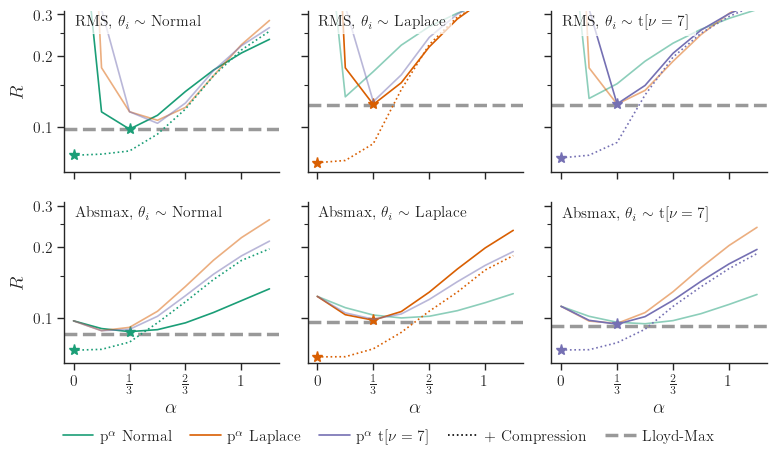

In [33]:
bits = 4
samples = 2**24
powers_except_zero = [1/6, 1/3, 1/2, 2/3, 5/6, 1, 7/6]
distributions = [A.Normal(), A.Laplace(), A.StudentT(7.)]
plt_args_compressed = dict(ls=":")
plt_args_lm = dict(ls="--", lw=2.5, alpha=.4, color="k")

grid = plot_utils.grid(rows=[("rms", None), ("absmax", 64)], cols=distributions,
                       sharex=True, sharey=True, height=2.25)
for ((scaling, block_size), dist), ax in grid:
    X, _ = Q.block_normalise(dist.sample(samples, seed=1, device=DEVICE), (block_size,), scaling, (-1, 1), Q.FP32)
    X_train, _ = Q.block_normalise(dist.sample(samples, seed=2, device=DEVICE), (block_size,), scaling, (-1, 1), Q.FP32)

    for d, color in zip(distributions, plot_utils.PALETTE):
        powers = powers_except_zero.copy()
        if scaling == "rms" and type(d) != A.StudentT:
            powers.insert(0, 0.001)
        if scaling =="absmax":
            powers.insert(0, 0)
        rmse = [Q.qrmse_norm(d.quantiser(bits, power=p, scaling=scaling, block_size=block_size), X).item() for p in powers]
        ax.plot(powers, rmse, color=color, alpha=1 if type(d) == type(dist) else 0.5)
        if type(d) == type(dist):
            idx = torch.argmin(tensor(rmse)).item()
            assert powers[idx] == 1/3
            ax.plot(powers[idx], rmse[idx], color=color, marker="*", ms=8)

    powers = [0] + powers_except_zero
    rmse = [Q.qrmse_norm(d.find_compressed_quantiser(bits, X=X, X_train=X_train, power=p, scaling=scaling, block_size=block_size), X).item()
            for p in powers]
    color = plot_utils.PALETTE[distributions.index(dist)]
    ax.plot(powers, rmse, color=color, **plt_args_compressed)
    idx = torch.argmin(tensor(rmse)).item()
    assert powers[idx] == 0
    ax.plot(powers[idx], rmse[idx], color=color, marker="*", ms=8)

    lm_rmse = Q.qrmse_norm(Q.lut_lloyd_max(X_train, bits, 1e-4, init=dict(rms=("uniform_rms", 3), absmax="uniform_minmax")[scaling]), X).item()
    ax.axhline(lm_rmse, **plt_args_lm, zorder=0)

    ax.text(0.05, 0.98, f"{plot_utils.display_name(scaling)}, $\\theta_i \\sim$ {distribution_name(dist)}",
            ha='left', va='top', transform=ax.transAxes,
            fontsize=11, bbox=dict(facecolor="white", alpha=.7))

for ax in grid.axes[:, 0]:  # left
    ax.set_yscale("log")
    ax.set_yticks([0.1, 0.2, 0.3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator([0.15, 0.25]))
    ax.set_ylim((0.064, 0.31))
    ax.yaxis.set_tick_params(which="minor", labelleft=False)
    ax.yaxis.set_major_formatter("{x}")
    ax.set_ylabel("qrmse_norm")

for ax in grid.axes[-1, :]:  # bottom
    ax.set_xticks([0, 1/3, 2/3, 1])
    ax.xaxis.set_major_formatter(plot_utils.format_fraction())
    ax.set_xlabel(r"$\alpha$")

plot_utils.set_figure_legend(grid.figure, build=[*[
        dict(color=color, label=f"$\\mathrm{{p}}^{{\\alpha}}$ {distribution_name(dist)}")
        for dist, color in zip(distributions, plot_utils.PALETTE)
    ],
        dict(**plt_args_compressed, label=f"+ Compression"),
        dict(**plt_args_lm, label=f"Lloyd-Max"),
    ],
    bbox_to_anchor=(0.0, 0.05, 1.0, 0), loc="upper center", ncols=5, columnspacing=1.25, handletextpad=0.4,
)
plot_utils.tidy(grid.figure)
plot_utils.save(f"analysis_power_sweep")

### `analysis_moment_matching_vs_search`

remote: Updating references: 100% (1/1)           


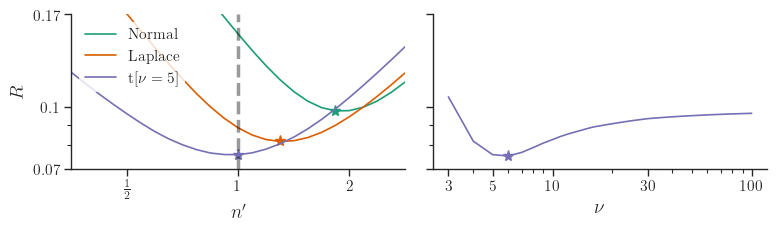

In [37]:
bits = 5
data_dist = A.StudentT(df=5.)
scaling = "rms"
X, _ = Q.block_normalise(data_dist.sample(2**24, seed=1, device=DEVICE), (None,), scaling, (-1, 1), Q.FP32)

figw, figh = matplotlib.rcParams["figure.figsize"]
_, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(figw, 0.85*figh))

distributions = [(dist, dict(color=c, label=distribution_name(dist)))
                 for dist, c in zip([A.Normal(), A.Laplace(), data_dist], plot_utils.PALETTE)]
moment_matching_args = dict(color="k", alpha=.4, lw=2.5, ls="--", label="Moment matching")
scales = 2 ** torch.linspace(-1.5, 1.5, 8*3+1)

for model_dist, args in distributions:
    rmse = tensor([Q.qrmse_norm(Q.ScaledFormat.create(model_dist.quantiser(bits, scaling=scaling), scale), X) for scale in scales])
    ax0.plot(scales, rmse.cpu(), **args)
    idx = torch.argmin(rmse).item()
    ax0.plot(scales[idx], rmse[idx], marker="*", ms=8, **args)
ax0.axvline(1, **moment_matching_args)

ax0.set_xscale("log", base=2)
ax0.xaxis.set_major_formatter(plot_utils.format_fraction())
ax0.set_xlim((scales[0], scales[-1]))
ax0.set_xlabel(r"$n^{\prime}$")

ax0.legend(handles=plot_utils.build_legend_handles(*distributions), loc="upper left")

def find_best_rmse(df: float) -> Tensor:
    return tensor([Q.qrmse_norm(Q.ScaledFormat.create(A.StudentT(df=df).quantiser(bits, scaling=scaling), scale), X) for scale in scales]).min()
dfs = torch.arange(3, 101)
rmse = tensor([find_best_rmse(df) for df in dfs])
ax1.plot(dfs, rmse.cpu(), color=plot_utils.PALETTE[2])
idx = torch.argmin(rmse).item()
ax1.plot(dfs[idx], rmse[idx], marker="*", ms=8, color=plot_utils.PALETTE[2])
ax1.set_xscale("log")
ax1.set_xticks([3, 5, 10, 30, 100])
ax1.set_xticklabels([3, 5, 10, 30, 100])
ax1.set_xlabel("df")

ax0.set_yscale("log")
ax0.yaxis.set_minor_formatter("{x:.1f}")
ax0.set_ylim((0.07, 0.17))
ax0.set_yticks([0.07, 0.1, 0.17])
ax0.set_yticklabels([0.07, 0.1, 0.17])
ax0.tick_params(which='minor', labelleft=False)
ax0.set_ylabel("qrmse_norm")

plot_utils.tidy(ax0.figure)
plot_utils.save("analysis_moment_matching_vs_search")

## Evaluation (iid data)

### `analysis_error_vs_bits`

remote: Updating references: 100% (1/1)           


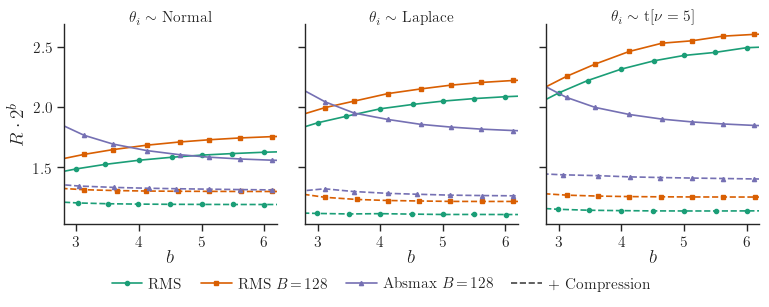

In [12]:
samples = 2**24
distributions = [A.Normal(), A.Laplace(), A.StudentT(df=5)]
b_elems = torch.arange(2.5, 6.5 + 0.1, 0.5).tolist()

block_size = 128
scaling_block_size = [
    ("rms", None, dict(label="RMS", marker="o", color=plot_utils.PALETTE[0])),
    ("rms", block_size, dict(label=f"RMS $B\\!=\\!{block_size}$", marker="s", color=plot_utils.PALETTE[1])),
    ("absmax", block_size, dict(label=f"Absmax $B\\!=\\!{block_size}$", marker="^", color=plot_utils.PALETTE[2])),
]

grid = plot_utils.grid(cols=distributions, sharey=True)
for (dist,), ax in grid:
    X = dist.sample(samples, seed=1, device=DEVICE)
    X_train = dist.sample(samples, seed=2, device=DEVICE)
    for scaling, block_size, args in scaling_block_size:
        quantiser_block_size = None if scaling == "rms" else block_size

        bs, ys = [], []
        for b_elem in b_elems:
            fmt = Q.LinearScalingFormat(
                dist.quantiser(b_elem, scaling=scaling, block_size=quantiser_block_size),
                Q.BFLOAT16, (block_size,), scaling=scaling,
            )
            b = fmt.count_bits(X.shape) / X.nelement()
            ys.append(Q.qrmse_norm(fmt, X).item() * 2**b)
            bs.append(b)
        ax.plot(bs, ys, **plot_utils.drop_label(args))

        bs, ys = [], []
        for b_elem in b_elems:
            fmt = Q.LinearScalingFormat(
                dist.find_compressed_quantiser(
                    b_elem,
                    Q.block_normalise(X, (block_size,), scaling, (-1, 1), Q.FP32)[0],
                    Q.block_normalise(X_train, (block_size,), scaling, (-1, 1), Q.FP32)[0],
                    scaling=scaling,
                    block_size=quantiser_block_size,
                ),
                Q.BFLOAT16, (block_size,), scaling=scaling,
            )
            b = fmt.count_bits_tensor(X) / X.nelement()
            ys.append(Q.qrmse_norm(fmt, X).item() * 2**b)
            bs.append(b)
        ax.plot(bs, ys, **plot_utils.drop_label(args), ls="--")

    ax.set_xlim((3-0.2, 6+0.2))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    ax.set_xlabel("bits", labelpad=0)
    ax.set_title(f"$\\theta_i \\sim$ {distribution_name(dist)}", pad=0)

ax0 = grid.axes[0, 0]
ax0.set_ylabel(r"$R \cdot 2^b$")
ax0.yaxis.set_major_formatter("{x}")
plot_utils.set_figure_legend(
    grid.figure,
    build=[*scaling_block_size, dict(color="#444", ls="--", label="+ Compression")],
    bbox_to_anchor=(0.0, 0.08, 1.0, 0), loc="upper center", ncols=4, columnspacing=1.25, handletextpad=0.4,
)

plot_utils.tidy(grid.figure)
plot_utils.save("analysis_error_vs_bits")

### `analysis_block_size`

remote: Updating references: 100% (1/1)           


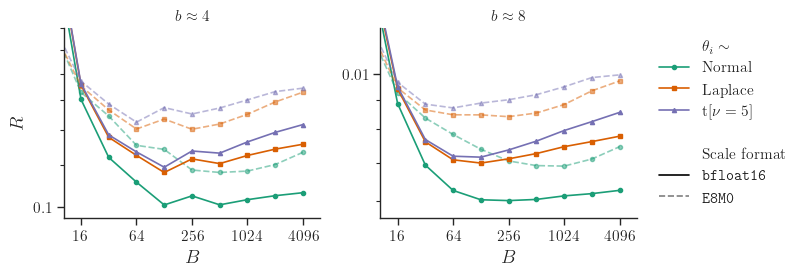

In [42]:
block_sizes = [2**logB for logB in range(3, 12+1)]
distributions = [
    (dist, dict(color=color, marker=marker, label=distribution_name(dist)))
    for dist, color, marker in zip(
        [A.Normal(), A.Laplace(), A.StudentT(df=5)],
        plot_utils.PALETTE,
        ["o", "s", "^"],
    )
]
scale_fmts = [
    (Q.BFLOAT16, dict(ls="-", label="BFLOAT16")),
    (Q.parse("EXP8"), dict(ls="--", alpha=.5, label="EXP8")),
]

grid = plot_utils.grid(cols=[4, 8])
for (b,), ax in grid:
    for dist, dist_args in distributions:
        X = dist.sample(2**24, seed=1, device=DEVICE)
        for scale_fmt, scale_args in scale_fmts:
            rmse = []
            for block_size in block_sizes:
                fmt = Q.LinearScalingFormat(
                    dist.quantiser(b - scale_fmt.bits / block_size, scaling="absmax", block_size=block_size, mode="symmetric"),
                    scale_fmt, (block_size,), scaling="absmax",
                )
                assert b - 0.125 <= fmt.count_bits(X.shape) / X.nelement() <= b + 0.125
                rmse.append(Q.qrmse_norm(fmt, X).item())
            ax.plot(block_sizes, rmse, **plot_utils.drop_label(dist_args), **plot_utils.drop_label(scale_args))

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x}")
    ax.tick_params(axis="y", which="minor", labelleft=False)
    ax.set_ylim({4: (0.095, 0.22), 6: (0.023, 0.045), 8: (0.0056, 0.012)}[b])

    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([16, 64, 256, 1024, 4096])
    ax.set_xlim((16 * 0.65, 4096 / 0.65))

    ax.set_xlabel("block_size")
    ax.set_title(f"$b \\approx {b}$")

grid.axes[0, 0].set_ylabel("qrmse_norm")
plot_utils.set_figure_legend(grid.figure, build=[r"$\theta_i \sim$", *distributions, "", "Scale format", *scale_fmts])
plot_utils.tidy(grid.figure)
plot_utils.save("analysis_block_size")

### `analysis_other_formats`

remote: Updating references: 100% (1/1)           


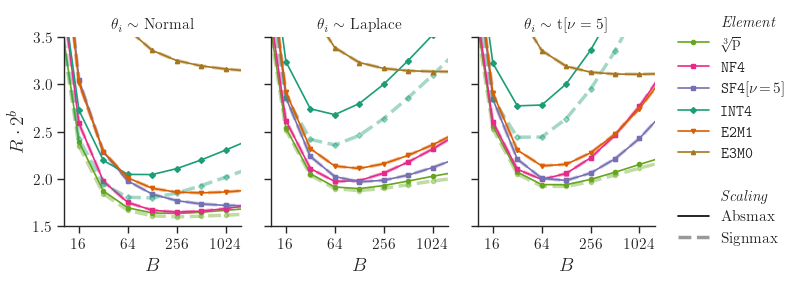

In [58]:
distributions = [A.Normal(), A.Laplace(), A.StudentT(df=5)]

element_formats = [
    (lambda dist, scaling, block_size: dist.quantiser(4, scaling=scaling, block_size=block_size, mode=dict(absmax="symmetric", signmax="asymmetric")[scaling]),
     dict(label=plot_utils.CRD_LABEL, marker="o", color=plot_utils.PALETTE[4])),
    (lambda *_: Q.NF4, dict(label="NF4", marker="s", color=plot_utils.PALETTE[3])),
    (lambda *_: Q.SF4_DF5, dict(label=r"\texttt{SF4}[$\nu\!=\!5$]", marker="s", color=plot_utils.PALETTE[2])),
    (lambda *_: Q.parse("E0M3"), dict(label="E0M3", marker="D", color=plot_utils.PALETTE[0])),
    (lambda *_: Q.parse("E2M1"), dict(label="E2M1", marker="v", color=plot_utils.PALETTE[1])),
    (lambda *_: Q.parse("E3M0"), dict(label="E3M0", marker="^", color=plot_utils.PALETTE[6])),
]

scaling_methods = [
    ("absmax", dict(ls="-", label="absmax")),
    ("signmax", dict(ls="--", alpha=.4, lw=2.5, label="signmax")),
]

block_sizes = [2**logB for logB in range(3, 11+1)]

grid = plot_utils.grid(cols=distributions, sharey=True)
for (dist,), ax in grid:
    X = dist.sample(2**24, seed=1, device=DEVICE)
    for efmt, efmt_args in element_formats:
        for scaling, scaling_args in scaling_methods:
            rmse = []
            for block_size in block_sizes:
                fmt = Q.LinearScalingFormat(efmt(dist, scaling, block_size), Q.BFLOAT16, (block_size,), scaling=scaling)
                bits = fmt.count_bits(X.shape)/X.nelement()
                rmse.append(Q.qrmse_norm(fmt, X).item() * 2**bits)
            ax.plot(block_sizes, rmse, **plot_utils.drop_label(efmt_args), **scaling_args)

    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([16, 64, 256, 1024])
    ax.set_xlim((16 * 0.65, 1024 / 0.65))
    ax.set_xlabel("block_size")
    ax.set_title(f"$\\theta_i \\sim$ {distribution_name(dist)}")

ax0 = grid.axes[0, 0]
ax0.set_ylim((1.5, 3.5))
ax0.yaxis.set_major_formatter("{x}")
ax0.set_ylabel(r"$R \cdot 2^b$")

plot_utils.set_figure_legend(grid.figure, build=[
    r"\textit{Element}",
    *element_formats,
    "",
    r"\textit{Scaling}",
    *scaling_methods,
])

plot_utils.tidy(grid.figure)
plot_utils.save("analysis_other_formats")

### `analysis_element_exponent_bits`

remote: Updating references: 100% (1/1)           


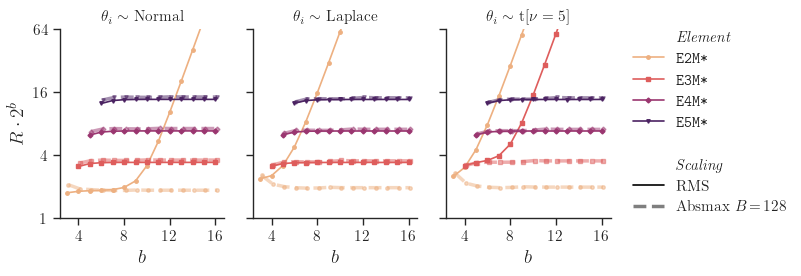

In [61]:
distributions = [A.Normal(), A.Laplace(), A.StudentT(df=5)]
bits = torch.arange(3, 17)
block_size = 128
ebits_items = [
    (ebits, dict(color=color, marker=marker, ms=2.5, label=f"\\texttt{{E{ebits}M*}}"))
    for ebits, color, marker in zip([2, 3, 4, 5], plot_utils.SEQ_PALETTE(torch.linspace(0, 1, 4)), "osDv")
]
scaling_methods = [
    ("rms", None, dict(ls="-", label="RMS")),
    ("absmax", block_size, dict(ls="--", alpha=.5, lw=2.5, label=f"Absmax $B\\!=\\!{block_size}$")),
]

grid = plot_utils.grid(cols=distributions, sharey=True)
for (dist,), ax in grid:
    X = dist.sample(2**24, seed=1, device=DEVICE)
    for scaling, block_size, scaling_args in scaling_methods:
        for ebits, ebits_args in ebits_items:
            fmts = [Q.LinearScalingFormat(Q.FPFormat(ebits, b - ebits - 1, "nearest"), Q.FPFormat(8, 7, "to_inf"), (block_size,), scaling)
                    for b in bits.tolist() if b - ebits - 1 >= 0]
            b = tensor([fmt.count_bits(X.shape) / X.nelement() for fmt in fmts])
            rmse = tensor([Q.qrmse_norm(fmt, X).item() for fmt in fmts])
            ax.plot(b, rmse * 2**b, **plot_utils.drop_label(scaling_args), **plot_utils.drop_label(ebits_args))
    ax.set_title(f"$\\theta_i \\sim$ {distribution_name(dist)}")
    ax.set_xlabel("bits")
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(4))

ax0 = grid.axes[0, 0]
ax0.set_yscale("log", base=2)
ax0.set_ylim((2**0, 2**6))
ax0.yaxis.set_major_formatter("{x:.0f}")
ax0.set_ylabel(r"$R \cdot 2^b$")

plot_utils.set_figure_legend(grid.figure, build=[
    r"\textit{Element}",
    *ebits_items,
    "",
    r"\textit{Scaling}",
    *scaling_methods,
])

plot_utils.tidy(grid.figure)
plot_utils.save("analysis_element_exponent_bits")

### `analysis_scale_mantissa_bits_t`

remote: Updating references: 100% (1/1)           


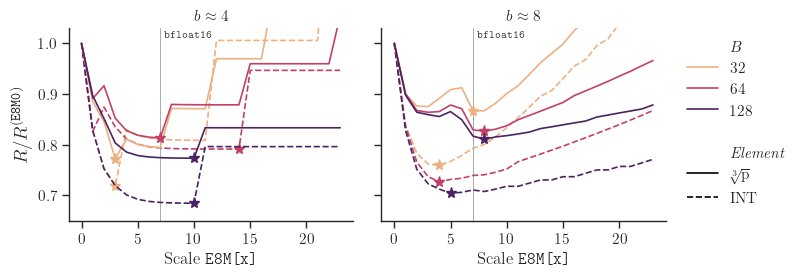

In [64]:
dist = A.StudentT(df=5)
scale_mantissa_bits = list(range(24))
element_formats = [
    (lambda b: dist.quantiser(b, scaling="absmax", block_size=block_size), dict(label=plot_utils.CRD_LABEL, ls="-", zorder=2)),
    (lambda b: Q.IntFormat(b), dict(label="INT", ls="--", zorder=1)),
]
block_sizes = [
    (block_size, dict(color=color, label=str(block_size)))
    for block_size, color in zip([32, 64, 128], plot_utils.SEQ_PALETTE(torch.linspace(0, 1, 3)))
]
bitss = [4, 8]

X = dist.sample(2**24, seed=1, device=DEVICE)
grid = plot_utils.grid(cols=bitss, sharey=True)
for (b,), ax in grid:
    for efmt, efmt_args in element_formats:
        for block_size, block_size_args in block_sizes:
            rmse = []
            for mbits in scale_mantissa_bits:
                scaled_fmt = Q.LinearScalingFormat(
                    efmt(b - (mbits + 8) / block_size), Q.FPFormat(7, mbits, "to_inf"), (block_size,), scaling="absmax",
                )
                assert abs(scaled_fmt.count_bits(X.shape) / X.nelement() - b) < 0.1
                rmse.append(torch.stack([Q.qrmse_norm(scaled_fmt, X*f) for f in torch.linspace(1, 2, 11)]).mean().item())
            ax.plot(scale_mantissa_bits, [r / rmse[0] for r in rmse],
                    **plot_utils.drop_label(efmt_args), **plot_utils.drop_label(block_size_args))
            idx = torch.argmin(tensor(rmse))
            ax.plot(scale_mantissa_bits[idx], rmse[idx] / rmse[0], marker="*", ms=8,
                    **plot_utils.drop_label(efmt_args), **plot_utils.drop_label(block_size_args))

    ax.axvline(7, color="#888", lw=0.5, zorder=0)
    ax.annotate(r"\texttt{bfloat16}", [7, 1.025], va="top", ha="left", fontsize=8, xytext=(3, 0), textcoords="offset points", color="#444")
    ax.set_xlabel(r"Scale \texttt{E8M[x]}", fontsize=12)
    ax.set_title(f"$b \\approx {b}$")

ax0 = grid.axes[0, 0]
ax0.set_ylim((0.65, 1.03))
ax0.set_ylabel(r"$R / R^{(\texttt{E8M0})}$")

plot_utils.set_figure_legend(grid.figure, build=["$B$", *block_sizes, "", r"\textit{Element}", *element_formats])
plot_utils.tidy(grid.figure)
plot_utils.save("analysis_scale_mantissa_bits_t")

### `analysis_practical_compression`

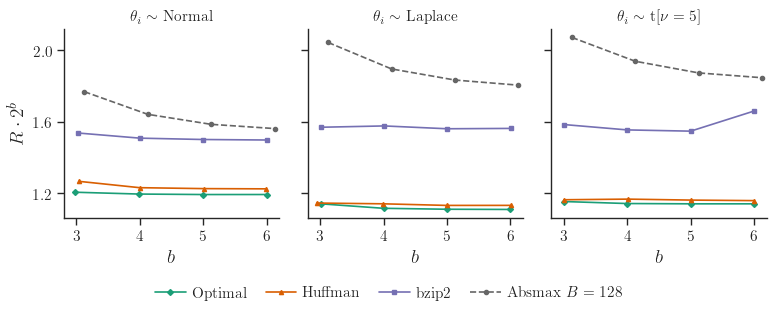

In [ ]:
# Warning - this is slow, as it runs practical compressors on CPU

samples = 2**20
distributions = [A.Normal(), A.Laplace(), A.StudentT(df=5)]
b_elems = torch.arange(3, 7).tolist()
block_size = 128
compressors = [
    ("optimal", dict(label="Optimal", marker="D", color=plot_utils.PALETTE[0])),
    ("huffman", dict(label="Huffman", marker="^", color=plot_utils.PALETTE[1])),
    # ("arithmetic", dict(label="Arithmetic", marker="v", color=plot_utils.PALETTE[2])),
    ("bz2", dict(label="bzip2", marker="s", color=plot_utils.PALETTE[2])),
]
block_args = dict(ls="--", marker="o", color="#666", label=f"Absmax $B={block_size}$")

grid = plot_utils.grid(cols=distributions, sharey=True)
for (dist,), ax in grid:
    X = dist.sample(samples, seed=1, device=DEVICE)
    X_train = dist.sample(samples, seed=2, device=DEVICE)
    for compressor, args in compressors:
        bs, ys = [], []
        for b_elem in b_elems:
            fmt = Q.LinearScalingFormat(
                dist.find_compressed_quantiser(
                    b_elem,
                    Q.block_normalise(X, (None,), "rms", (-1, 1), Q.FP32)[0],
                    Q.block_normalise(X_train, (None,), "rms", (-1, 1), Q.FP32)[0],
                    scaling="rms",
                    block_size=None,
                    compressor=compressor,
                ),
                Q.BFLOAT16, (None,), scaling="rms",
            )
            b = fmt.count_bits_tensor(X) / X.nelement()
            bs.append(b)
            ys.append(Q.qrmse_norm(fmt, X).item() * 2**b)
        ax.plot(bs, ys, **plot_utils.drop_label(args))

    bs, ys = [], []
    for b_elem in b_elems:
        fmt = Q.LinearScalingFormat(dist.quantiser(b_elem, "absmax", block_size), Q.BFLOAT16, (block_size,), "absmax")
        b = fmt.count_bits(X.shape) / X.nelement()
        bs.append(b)
        ys.append(Q.qrmse_norm(fmt, X).item() * 2**b)
    ax.plot(bs, ys, **plot_utils.drop_label(block_args))

    ax.set_xlim((3-0.2, 6+0.2))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.set_xlabel("bits")
    ax.set_title(f"$\\theta_i \\sim$ {distribution_name(dist)}")

ax0 = grid.axes[0, 0]
ax0.set_ylabel(r"$R \cdot 2^b$")
ax0.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.4))
plot_utils.set_figure_legend(
    grid.figure,
    build=[*compressors, block_args],
    bbox_to_anchor=(0.0, 0.05, 1.0, 0), loc="upper center", ncols=5, columnspacing=1.25, handletextpad=0.4,
)
plot_utils.tidy(grid.figure)
plot_utils.save("analysis_practical_compression")